In [78]:
import bayesflow as bf
import numpy as np
from numba import jit
from scipy import stats
from multiprocessing import Pool
import pickle
import tensorflow as tf
rng = np.random.default_rng()


In [64]:
# Define hierarchical prior functions

def hierarchical_prior_fun():
    
    hyper_mu_v = rng.normal(2.00, 2.00)
    hyper_sigma_v = stats.halfnorm.rvs(0.01, 2.0)

    hyper_mu_a = rng.gamma(1.5, 0.75)
    hyper_sigma_a = stats.halfnorm.rvs(0.01, 0.3)

    hyper_mu_t = rng.gamma(0.4, 0.2)
    hyper_sigma_t = stats.halfnorm.rvs(0.01, 0.5)

    return np.concatenate([np.r_[hyper_mu_v, hyper_sigma_v, hyper_mu_a, hyper_sigma_a, hyper_mu_t, hyper_sigma_t]])


def local_prior_fun(hyper_theta=hierarchical_prior_fun, n_people = 50):
    a_a, b_a = (0.01 - hyper_theta[2]) / hyper_theta[3], (12 - hyper_theta[2]) / hyper_theta[3]    
    a_t, b_t = (0.01 - hyper_theta[4]) / hyper_theta[5], (5 - hyper_theta[4]) / hyper_theta[5]    
    v = rng.normal(hyper_theta[0], hyper_theta[1], size = n_people)
    a = stats.truncnorm.rvs(loc=hyper_theta[2], scale=hyper_theta[3], a= a_a, b= b_a, size = n_people)
    t = stats.truncnorm.rvs(loc=hyper_theta[4], scale=hyper_theta[5], a= a_t, b= b_t, size = n_people)
    return np.stack((v, a, t), axis=1)

prior = bf.simulation.TwoLevelPrior(hyper_prior_fun =  hierarchical_prior_fun, local_prior_fun = local_prior_fun)
prior(batch_size=3)

{'hyper_parameters': array([[-1.07316510e+00,  1.88401923e+00,  2.76137377e+00,
          4.78215291e-01,  2.37023943e-03,  4.00308856e-01],
        [ 5.18357215e+00,  2.12922034e+00,  1.59319193e+00,
          3.32035556e-01,  1.02785264e-01,  6.90059813e-01],
        [ 2.67353841e+00,  3.30313008e+00,  2.43264815e+00,
          1.80630409e-01,  4.43616166e-02,  7.93322224e-02]]),
 'local_parameters': array([[[ 2.92598879e+00,  2.71466473e+00,  2.62851919e-01],
         [-1.04352059e+00,  3.43428147e+00,  2.28868485e-01],
         [ 8.90107584e-01,  3.06666738e+00,  2.89685638e-01],
         [-1.79910384e+00,  2.94065863e+00,  2.44817802e-01],
         [-2.01883740e+00,  2.67336160e+00,  3.50754263e-01],
         [-3.29104858e+00,  2.72995011e+00,  6.92060081e-02],
         [-8.78932299e-01,  3.28682153e+00,  3.72019432e-01],
         [-4.37749769e-02,  2.70297638e+00,  4.66238748e-01],
         [-1.89231675e+00,  2.64223062e+00,  2.35050226e-01],
         [ 8.02279632e-01,  2.6024334

In [65]:
# Define hierarchical simulator function
@jit(nopython=True)

def diffusion_trial(v, a, ndt):
    """Simulates a trial from the diffusion model."""
    n_steps = 0.
    dt = 0.001
    max_steps = 10000
    x = a * 0.5
    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    rt = rt + ndt 
    if x <= 0:
      rt = -rt  
    
    return rt

def minimal_hierarchical_simulator(theta, num_obs=100):

    num_participants = theta.shape[0]
    out = np.zeros((num_participants, num_obs))
    for j in range(num_participants): # loop over participants
        for k in range(num_obs): # loop over observations
            out[j, k] = diffusion_trial(theta[j,0],theta[j,1],theta[j,2])
    return out

In [66]:
simulator = bf.simulation.Simulator(simulator_fun=minimal_hierarchical_simulator)
model = bf.simulation.TwoLevelGenerativeModel(prior=prior, simulator=simulator, name="DDM Toy")

INFO:root:Performing 2 pilot runs with the DDM Toy model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 50, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 100)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 50, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [67]:
# Define minimal configurator

def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    out_dict["summary_conditions"] = np.expand_dims(forward_dict["sim_data"], axis=3)

    # Get data generating parameters
    out_dict["local_parameters"] = forward_dict["local_prior_draws"].astype(np.float32)

    # Get data generating parameters
    out_dict["hyper_parameters"] = forward_dict["hyper_prior_draws"].astype(np.float32)

    return out_dict

In [68]:
# Define networks

summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(summary_dim=6), 
    bf.networks.DeepSet(summary_dim=150)
])

local_inference_net = bf.networks.InvertibleNetwork(
    num_params=3,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="local_ddm_inference"
)

hyper_inference_net = bf.networks.InvertibleNetwork(
    num_params=6,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="hyper_ddm_inference"
)

local_amortizer = bf.amortizers.AmortizedPosterior(local_inference_net, name="local_amortizer")
hyper_amortizer = bf.amortizers.AmortizedPosterior(hyper_inference_net, name="hyper_amortizer")
twolevel_amortizer = bf.amortizers.TwoLevelAmortizedPosterior(summary_net = summary_net,
                                                            local_amortizer = local_amortizer,
                                                            global_amortizer = hyper_amortizer)

In [69]:
model(1)

{'sim_data': array([[[ 0.66130061,  0.72330061, -0.67030061, ...,  0.79430061,
           0.66430061,  0.73330061],
         [ 1.44760933,  1.44360933,  1.45160933, ...,  1.44860933,
          -1.44760933, -1.46260933],
         [ 0.27448552,  0.29648552,  0.28748552, ...,  0.44848552,
           0.24348552,  0.21648552],
         ...,
         [ 0.30294995, -0.30194995,  0.30194995, ..., -0.30194995,
           0.30194995, -0.30294995],
         [-1.65733806,  1.65733806,  1.65833806, ..., -1.65733806,
          -1.65733806,  1.65733806],
         [-0.28132969,  0.26932969,  0.28432969, ...,  0.29232969,
           0.31532969, -0.26732969]]]),
 'hyper_prior_draws': array([[2.36332803, 0.3893389 , 0.38380887, 0.39298944, 0.00523572,
         0.65353602]]),
 'local_prior_draws': array([[[2.54955606, 0.59746374, 0.63230061],
         [2.30423263, 0.24876734, 1.43760933],
         [2.21889539, 0.6709903 , 0.17948552],
         [2.30741481, 0.44254638, 0.59415985],
         [2.34816509, 0.

In [77]:
 # Presimulate
NUM_ITERATIONS_PER_EPOCH = 1000
NUM_EPOCHS = 60
NUM_PROCESSES = 15
BATCH_SIZE = 32
FULL_PRESIM_PATH = "sims"

def f_mischa(x, presim_path='sims'):
    """
    Perform simulations for a given index and save results to a specified path.
    All simulation results are first collected into a list file_list, and then the entire list is written to the file in one go outside of the loop.

    Args:
        x (int): The current index or epoch number for which to generate and save simulation results.
        presim_path (str, optional): The file path to the directory where simulation results should be stored. Defaults to 'sims'.
    """

    # Initialize a list to hold simulated data for each iteration
    file_list = [{} for _ in range(NUM_ITERATIONS_PER_EPOCH)]

    # Generate simulated data for each iteration
    for k in range(NUM_ITERATIONS_PER_EPOCH):
        file_list[k] = model(BATCH_SIZE)  # Replace with actual simulation data

    # Construct the full path to the output file
    file_path = f'{presim_path}/presim_file_{x}.pkl'

    # Save the simulated data to a pickle file
    with open(file_path, 'wb+') as f:
        pickle.dump(file_list, f)

with Pool(processes=NUM_PROCESSES) as pool:
    pool.map(f_mischa, range(NUM_EPOCHS))

In [79]:
#Actual training from pre-simulated data (for speed)
optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         0.001, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=0.0, name=None))

trainer = bf.trainers.Trainer(generative_model=model, amortizer=twolevel_amortizer, configurator=configurator,checkpoint_path ="test2")
losses = trainer.train_from_presimulation(FULL_PRESIM_PATH, optimizer = optimizer)

#history = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32)


2024-07-26 00:06:17.117945: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-07-26 00:06:37.222689: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5da016b4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-26 00:06:37.222725: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2024-07-26 00:06:37.248738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-26 00:06:37.398139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1721945197.454485    5960 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/1000 [00:00<?, ?it/s]

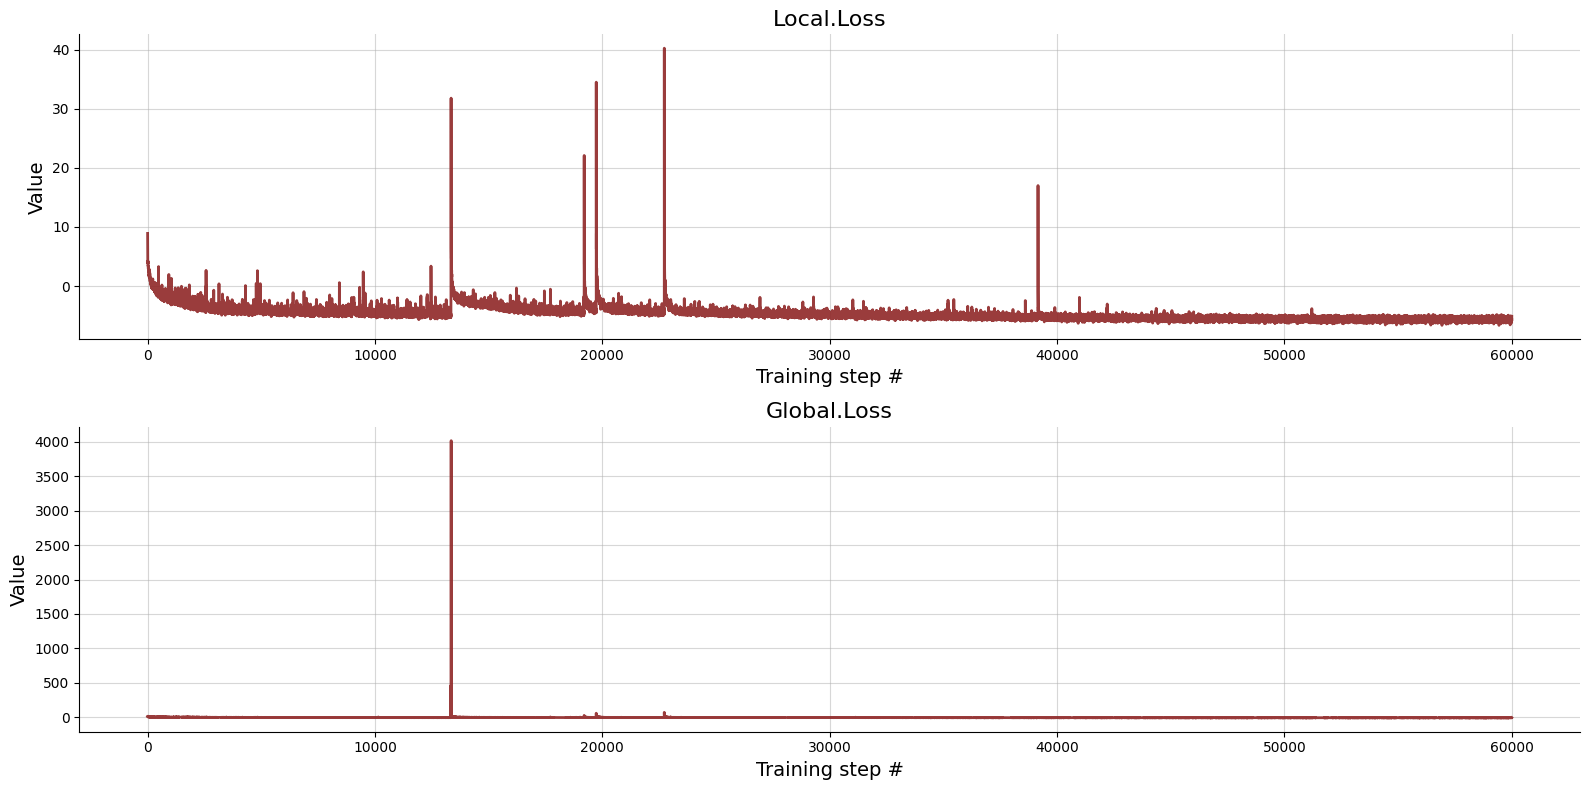

In [81]:
# Plot losses

f = bf.diagnostics.plot_losses(losses)

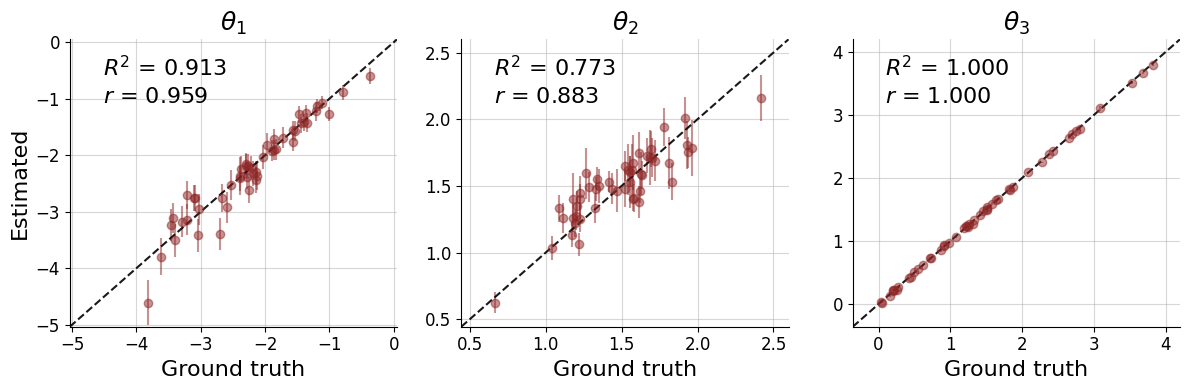

In [97]:
# Plot recovery of local parameters

validation_sims = configurator(model(batch_size=1))
prior_samples = np.squeeze(validation_sims["local_parameters"], axis=0)
post_samples = twolevel_amortizer.sample(validation_sims, n_samples=3000)

f = bf.diagnostics.plot_recovery(
    post_samples["local_samples"],
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)

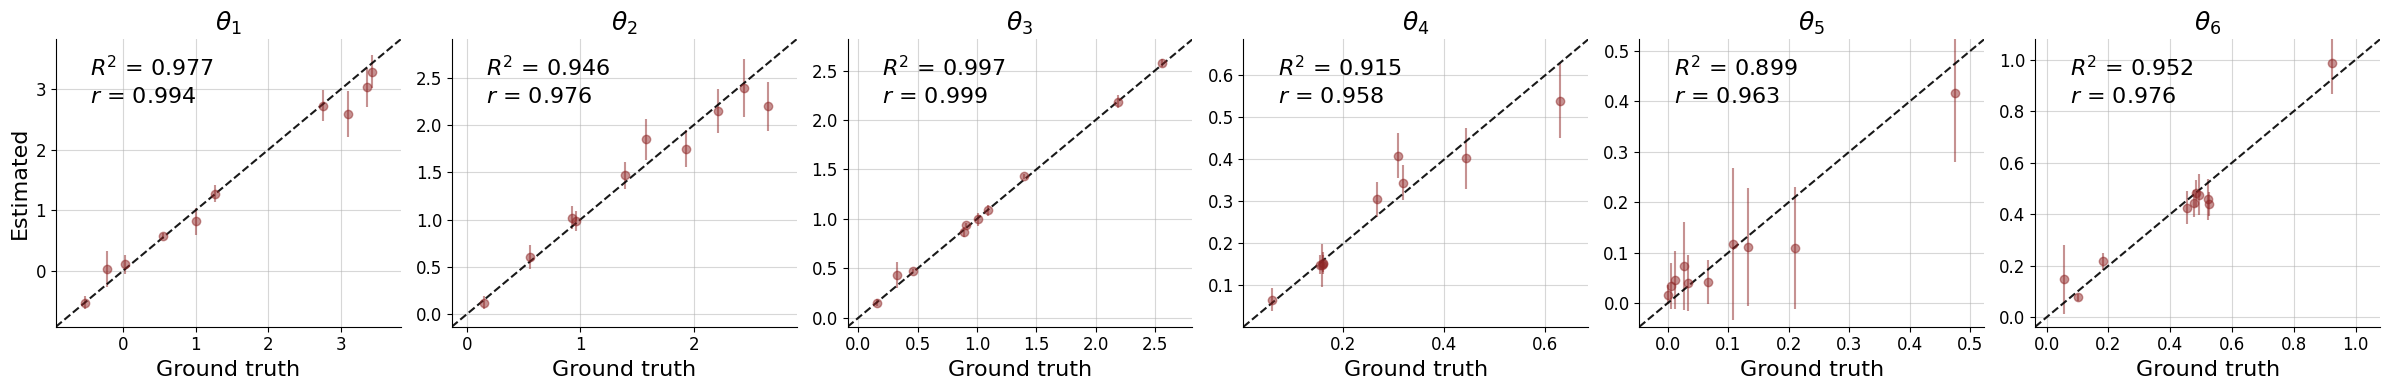

In [95]:
# Plot recovery of hyper parameters
batch_size = 10

prior_samples = validation_sims["hyper_parameters"]
post_samples = np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=3000)["global_samples"], axis=0)

for batch in range(batch_size-1):
    validation_sims = configurator(model(1))
    prior_samples = np.concatenate((prior_samples, validation_sims["hyper_parameters"]), axis=0)
    post_samples = np.concatenate((post_samples,
                                   np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=3000)["global_samples"], axis=0)), axis=0)

f = bf.diagnostics.plot_recovery(
    post_samples,
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)

In [ ]:
Z